CONTENTS LIST:
- Creating crosstabs
- Creating a regional segmentation for data
- Creating exclusion column
- Creating customer profiles
- Aggregating and visualizing customer profiles in comparison with other variables

#01 Importing libraries and data

In [4]:
#importing libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [5]:
#importing data
path = '/Users/gingermoore/Documents/04-2025 Instacart Basket Analysis'
df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'ords_prods_cust.pkl'))

In [6]:
df.columns

Index(['user_id', 'Gender', 'State', 'Age', 'date_joined', 'dependents',
       'fam_status', 'income', 'product_id', 'product_name', 'aisle_id',
       'department_id', 'prices', 'order_id', 'orders_chronological',
       'orders_day_of_week', 'order_hour_of_day', 'days_since_prior_order',
       'is_new', 'add_to_cart_order', 'reordered', 'price_range',
       'busiest_days', 'busiest_period_of_day', 'max_order', 'loyalty_flag',
       'avg_order_total', 'spending_flag', 'median_days', 'frequency_flag'],
      dtype='object')

I eliminated the names of the customers during exercise 4.9 since that data was extraneous. I believe that was the only PII involved, so there should not need to be any further concern.

#02 Creating regional segmentation

In [9]:
#defining values for region column
region = []
for value in df['State']:
    if value in ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']:
        region.append('Northeast')
    elif value in ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota',
                   'Iowa', 'Missouri']:
        region.append('Midwest')
    elif value in ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Florida',
                   'Georgia', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']:
        region.append('South')
    else:
        region.append('West')

In [10]:
#creating column for new values
df['region'] = region

In [11]:
df['region'].value_counts(dropna = False)

region
South        10790096
West          8291679
Midwest       7596065
Northeast     5721892
Name: count, dtype: int64

In [12]:
#creating crosstab to find differences in spending habits
crosstab = pd.crosstab(df['region'], df['spending_flag'], dropna = False)

In [13]:
crosstab.to_clipboard()

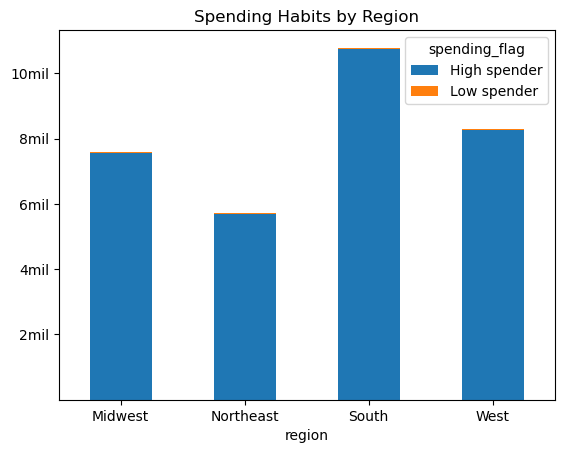

In [14]:
#attempting to create a stacked bar chart
spending = crosstab.plot(kind = 'bar', stacked = True, rot=0)
plt.title('Spending Habits by Region')
plt.yticks([2000000, 4000000, 6000000, 8000000, 10000000], ['2mil', '4mil', '6mil', '8mil', '10mil'])
plt.show()

#03 Creating exclusion flag

In [16]:
#creating conditions
df.loc[df['max_order'] < 5, 'exclude'] = 'low-activity'

In [17]:
df.loc[df['max_order'] >= 5, 'exclude'] = 'regular-activity'

In [18]:
#checking the values
df['exclude'].value_counts(dropna=False)

exclude
regular-activity    30959687
low-activity         1440045
Name: count, dtype: int64

In [19]:
#new dataframe with only the regular-activity customers
df_2 = df[df['exclude'] == 'regular-activity']

In [20]:
df_2['exclude'].value_counts(dropna = False)

exclude
regular-activity    30959687
Name: count, dtype: int64

In [21]:
#exporting sample as requested
df_2.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'ords_prods_cust_exclude_low_activity.pkl'))

#04 Creating customer profiles

In [23]:
#finding min and max ages in dataframe
df_2['Age'].min()

18

In [24]:
df_2['Age'].max()

81

In [25]:
#Creating conditions for customer profile
df_2.loc[df_2['dependents'] == 0, 'customer_profile'] = 'single adult'

/var/folders/dt/_2cmd91j32bgtvjmx8m320w40000gn/T/ipykernel_44285/4278238225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.loc[df_2['dependents'] == 0, 'customer_profile'] = 'single adult'


In [26]:
df_2.loc[(df_2['dependents'] >=1) & (df_2['Age'] >=18) & (df_2['Age'] <=35), 'customer_profile'] = 'young parent'

In [27]:
df_2.loc[(df_2['Age'] >=36) & (df_2['Age'] <= 55), 'customer_profile'] = 'midlife'

In [28]:
df_2.loc[(df_2['Age'] > 55), 'customer_profile'] = 'senior adult'

In [29]:
df_2['customer_profile'].value_counts()

customer_profile
senior adult    12506286
midlife          9716005
young parent     6560029
single adult     2177367
Name: count, dtype: int64

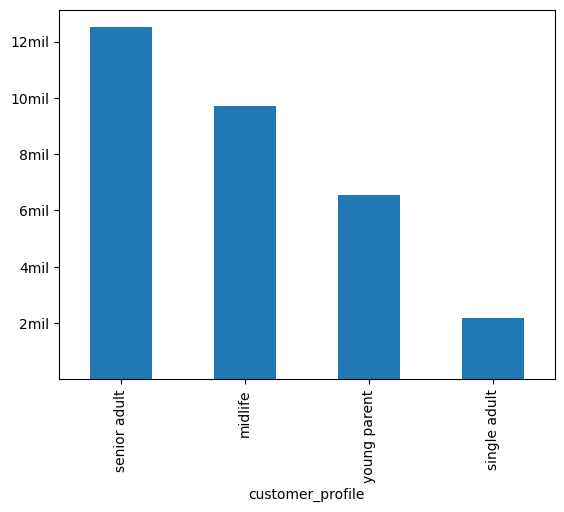

In [30]:
#visualizing customer profiles
profiles = df_2['customer_profile'].value_counts().plot.bar()
plt.yticks([2000000, 4000000, 6000000, 8000000, 10000000, 12000000], ['2mil', '4mil', '6mil', '8mil', '10mil', '12mil']);

#05 Aggregating customer profiles

In [32]:
#Creating aggregation
df_2.groupby('customer_profile').agg({
    'days_since_prior_order': ['mean', 'min', 'max'],
    'prices': ['mean', 'min', 'max']
})

days_since_prior_order               prices           
                                   mean  min   max      mean  min   max
customer_profile                                                       
midlife                       10.800543  0.0  30.0  7.789587  1.0  25.0
senior adult                  10.804533  0.0  30.0  7.795802  1.0  25.0
single adult                  10.898356  0.0  30.0  7.780360  1.0  25.0
young parent                  10.805916  0.0  30.0  7.785536  1.0  25.0

#06 Comparing profiles to departments and regions

In [34]:
#comparing with departments
dept = pd.crosstab(df_2['department_id'], df_2['customer_profile'], dropna = False)

In [35]:
dept.to_clipboard()

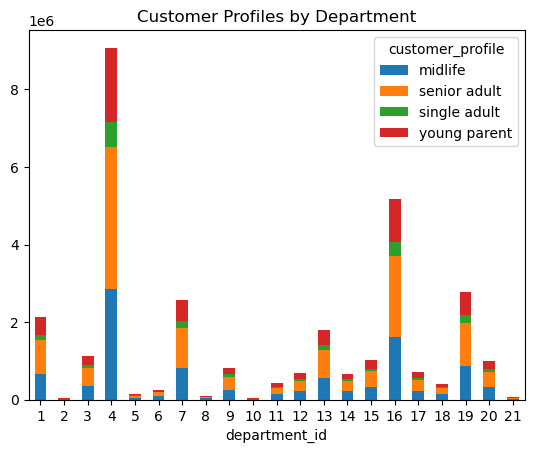

In [36]:
depts = dept.plot(kind = 'bar', stacked = True, rot = 0)
plt.title('Customer Profiles by Department')
plt.show()

In [37]:
#comparing with regions
cust_region = pd.crosstab(df_2['region'], df_2['customer_profile'], dropna = False)

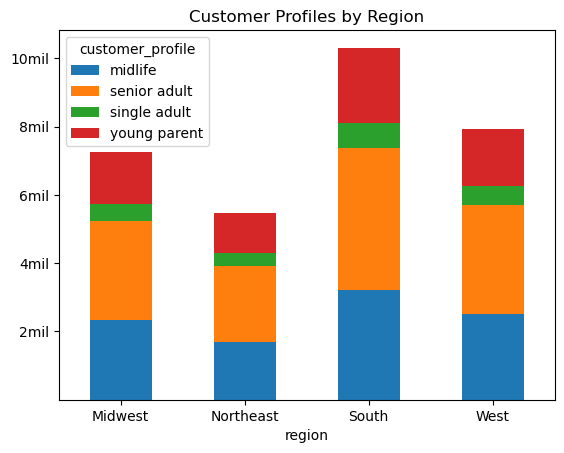

In [38]:
region = cust_region.plot(kind = 'bar', stacked = True, rot = 0)
plt.title('Customer Profiles by Region')
plt.yticks([2000000, 4000000, 6000000, 8000000, 10000000], ['2mil', '4mil', '6mil', '8mil', '10mil'])
plt.show()

#07 Exporting charts

In [40]:
spending.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'spending_by_region.png'))

In [41]:
profiles.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'customer_profiles.png'))

In [42]:
depts.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'cust_prof_by_dept.png'))

In [43]:
region.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'cust_prof_by_region.png'))

#08 Exporting dataset

In [81]:
df_2.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'final_dataset.pkl'))